In [1]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# project = 'hiue/lowrank-fedrec-2'
# project = 'hiue/lora-fedrec-3'
project = 'hiue/lora-fedrec'
api = wandb.Api()
runs = api.runs(project, {
    "$and": [{
        'config.data.name': 'movielens',
        'config.task_name': 'fedtrain',
        'config.model.init._target_': {
            '$in': ['fedlib.standard.models.FedMF',
                    'fedlib.lora.models.FedLoraMF']
        },
        # 'config.dataloader.batch_size': 32,
        # 'config.data.name': 'foursq-ny',
        # 'config.task_name': 'fedsweep3',
        # 'config.dataloader.batch_size': 16,
        # 'config.trainer.lr': 5e-3,

        # 'config.data.name': 'foursq-ny',
        # 'config.dataloader.batch_size': 16,
        # 'config.trainer.lr': 7e-3,
        'tags': {
            "$in": ['selected']
        },
        # 'config.data.name': 'pinterest',
        # 'config.task_name': 'fedtrain5',    
        # 'state': 'finished'
        }]
})

In [3]:
lora_runs = []
svd_runs = []
normal_runs = []

update_numels = []
all_HR = []
all_NDCG = []
all_loss = []

histories = {}

for run in runs:
    print("Name: {}, Id: {}".format(run.name, run.id))
    if 'lora' in run.name:
        if run.config['model']['init']['lora_rank'] == run.config['model']['init']['lora_alpha']:
            lora_runs.append(run)
        else:
            continue
    elif 'svd' in run.name:
        svd_runs.append(run)
    else:
        normal_runs.append(run)
    update_numels.append(run.summary['update_numel'])
    # histories[run.name] = run.history(samples=20)
    histories[run.name] = run.scan_history(keys=['train/loss', 'test/HR', 'test/NDCG', 'epoch'])
    # all_HR.append(run.history()['HR'].max())
    # all_NDCG.append(run.history()['NDCG'].max())
    # all_loss.append(run.history()['train_loss'].min())

Name: fedmf64_lora16_freezeB-60-2-32, Id: 2p2213dr
Name: fedmf64-svd32-60-2-31, Id: 1j8npinb
Name: fedmf64-svd16-60-2-30, Id: 2u5cfjzk
Name: fedmf64-svd8-60-2-29, Id: 1od9890o
Name: fedmf64-svd4-60-2-28, Id: 1zvl5qsb
Name: fedmf64-svd2-60-2-22, Id: 3bx7hx1r
Name: fedmf64_lora8_freezeB-60-2-20, Id: 6vrftske
Name: fedmf64_lora32_freezeB-60-2-17, Id: 9tjsf2bd
Name: fedmf64_lora4_freezeB-60-2-13, Id: t30yevf7
Name: fedmf64_lora2_freezeB-60-2-12, Id: 7umzn7g0
Name: fedmf8-60-2-10, Id: obglmc1u
Name: fedmf2-60-2-9, Id: j64pmxch
Name: fedmf4-60-2-8, Id: wocvwq5l
Name: fedmf16-60-2-7, Id: uxxge11y
Name: fedmf32-60-2-6, Id: 9s9x6xvu
Name: fedmf64-60-2-5, Id: uazt2ao6


In [33]:
normal_runs_names = [run.name for run in normal_runs]
normal_runs_names
# df = lora_runs[0].history()
# df['fit'].mean() + df['set_parameters'].mean() + df['get_parameters'].mean() + df['compress'].mean()
# fit_times = []
# set_parameters_times = []
# get_parameters_times = []
# compression_times = []

# for row in df:
#     print(row)
#     fit_times.append(row['fit'])
#     set_parameters_times.append(row['set_parameters'])
#     get_parameters_times.append(row['get_parameters'])
#     compression_times.append(row['compression'])

['fedmf8-60-2-10',
 'fedmf2-60-2-9',
 'fedmf4-60-2-8',
 'fedmf16-60-2-7',
 'fedmf32-60-2-6',
 'fedmf64-60-2-5']

In [4]:
cached_hist = {}
for k, v in histories.items():
    cached_hist[k] = {}
    cached_hist[k]['test/HR'] = [row['test/HR'] for row in v]
    cached_hist[k]['test/NDCG'] = [row['test/NDCG'] for row in v]
    cached_hist[k]['train/loss'] = [row['train/loss'] for row in v]
    cached_hist[k]['epoch'] = [row['epoch'] for row in v]

In [20]:
cached_hist[run.name]['test/HR']

[]

In [35]:
normal_runs[-2].summary['test/NDCG']

0.3840011060237885

In [4]:
def scatter_plot(ax, runs, metric, label=None, marker='o', linestyle='dashed', color=None, rescale_x=None, min_value=False, text_offset=0.02):
    x = []
    y = []
    for run in runs:
        x_val = run.summary['update_numel']
        if rescale_x is not None:
            x_val = x_val / rescale_x
        x.append(x_val)

        y_val = run.summary[metric]
        # y_val = cached_hist[run.name][metric][np.argmin(cached_hist[run.name]['train/loss'])]
        # metric = metric.split('/')[-1]
        # print(metric)
        # y_val = min(cached_hist[run.name][metric]) if min_value else max(cached_hist[run.name][metric])
        y.append(y_val)
        # if 'lora' in run.name:
        #     lora_rank = run.config['model']['init']['lora_rank']
        #     # ax.text(x_val, y_val+text_offset, f"r={lora_rank}", fontsize=8)
        #     ax.annotate(f"r={lora_rank}", (x_val, y_val), xytext=(x_val, y_val+text_offset), fontsize=8)
        # else:
        #     emb_size = run.config['model']['init']['gmf_emb_size']
        #     ax.text(x_val, y_val-text_offset, f"d={emb_size}", fontsize=8)

    ids = np.argsort(x)
    x = np.array(x)[ids]
    y = np.array(y)[ids]
    ax.plot(x, y, label=label, marker=marker, linestyle=linestyle, color=color)

Text(0, 0.5, 'Train loss')

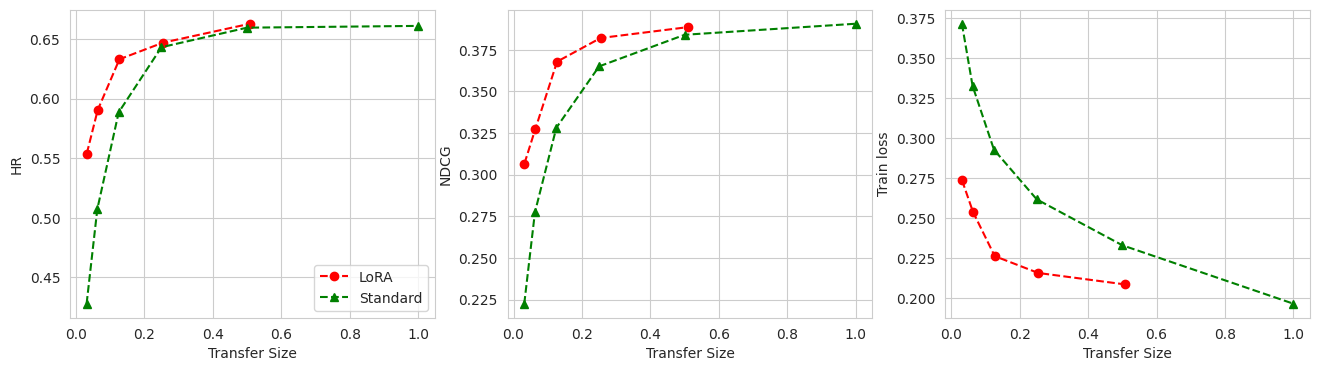

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.set_style("whitegrid")
scatter_plot(axes[0], lora_runs, 'test/HR', label='LoRA', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels), text_offset=0.02)
# scatter_plot(axes[0], svd_runs, 'test/HR', label='SVD', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels), text_offset=0.02)
scatter_plot(axes[0], normal_runs, 'test/HR', label='Standard', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels), text_offset=0.02)
axes[0].set_xlabel('Transfer Size')
axes[0].set_ylabel('HR')
axes[0].legend()
# axes[0].set_ylim([0.1, 0.5])
# axes[0].axhline(y=max(all_HR), color='black', linestyle='-.')

scatter_plot(axes[1], lora_runs, 'test/NDCG', label='LoRA', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels), text_offset=0.01)
# scatter_plot(axes[1], svd_runs, 'test/NDCG', label='SVD', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels), text_offset=0.01)
scatter_plot(axes[1], normal_runs, 'test/NDCG', label='Standard', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels), text_offset=0.01)
axes[1].set_xlabel('Transfer Size')
axes[1].set_ylabel('NDCG')
# axes[1].set_ylim([0.15, 0.3])
# axes[1].axhline(y=max(all_NDCG), color='black', linestyle='-.')


scatter_plot(axes[2], lora_runs, 'train/loss', label='LoRA', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels), min_value=True, text_offset=0.01)
# scatter_plot(axes[2], svd_runs, 'train/loss', label='SVD', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels), min_value=True, text_offset=0.01)
scatter_plot(axes[2], normal_runs, 'train/loss', label='Standard', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels), min_value=True, text_offset=0.01)
axes[2].set_xlabel('Transfer Size')
axes[2].set_ylabel('Train loss')
# axes[2].set_ylim([0.4, 0.6])

In [8]:
fig.savefig('figures/ml_fedmf-summary-v2.pdf', bbox_inches='tight')

In [9]:
def plot_hist(run_name, axes, label, **style_kwargs):
    HR = cached_hist[run_name]['HR']
    NDCG = cached_hist[run_name]['NDCG']
    train_loss = cached_hist[run_name]['train_loss']
    epoch = cached_hist[run_name]['epoch']

    axes[0].plot(epoch, HR, label=label, **style_kwargs)
    axes[0].set_xlabel('Communication Rounds')
    axes[0].set_ylabel('Metric')
    

    axes[1].plot(epoch, NDCG, label=label, **style_kwargs)
    axes[1].set_xlabel('Communication Rounds')
    axes[1].set_ylabel('NDCG')

    axes[2].plot(epoch, train_loss, label=label, **style_kwargs)
    axes[2].set_xlabel('Communication Rounds')
    axes[2].set_ylabel('Train loss')


In [10]:
color_set = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
marker_set = ['o', 'x', '^', 'v', 's', 'p', '*', 'h', 'D', 'P']

KeyError: 'fedmf64-550-2-229'

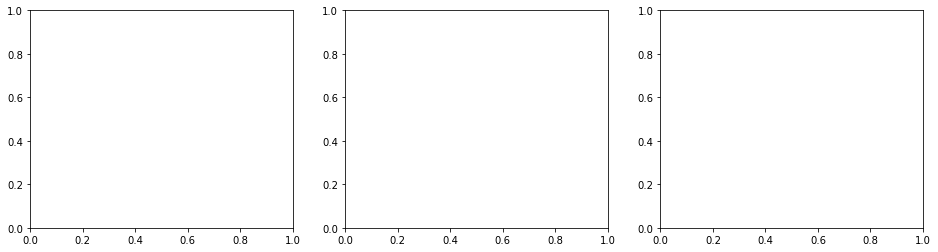

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
style_1 = {'marker':marker_set[0], 'linestyle':'-', 'color':color_set[0]}
plot_hist('fedmf64-550-2-229', axes, label="Base", **style_1)

style_2 = {'marker':marker_set[1], 'linestyle':'--', 'color':color_set[1]}
plot_hist('fedmf64_lora16_freezeB-550-2-227', axes, label="Lora-16", **style_2)

style_3 = {'marker':marker_set[2], 'linestyle':'--', 'color':color_set[2]}
plot_hist('fedmf64_lora8_freezeB-550-2-226', axes, label="Lora-8", **style_3)

style_4 = {'marker':marker_set[3], 'linestyle':'--', 'color':color_set[3]}
plot_hist('fedmf64_lora4_freezeB-550-2-225', axes, label="Lora-4", **style_4)

axes[0].legend()

## PCA of transfered param

In [19]:
# df = pd.read_csv("/home/hieunn/workspace/fedrec/LoRA-FedRec/FederatedTraining/outputs/est_pca/pinterest/fedmf32/bs=32_lr=0.5_cl=550_lep=2/2023-09-26_17-08-24/pca_var.csv")
df = pd.read_csv("/home/hieunn/workspace/fedrec/LoRA-FedRec/FederatedTraining/outputs/fedtrain/movielens/fedmf64/bs=64_lr=0.1_cl=60_lep=2/2023-09-26_18-48-22/pca_var.csv")

In [20]:
def count_important_components(explained_variance_ratio_, threshold=0.95):
    count = 0
    total = 0
    for ratio in explained_variance_ratio_:
        count += 1
        total += ratio
        if total >= threshold:
            break
    return count

In [21]:
df['count_important_95'] = df.mf_item_emb_explain_variance_ratio.apply(lambda x: count_important_components(map(float, x[1:-1].split()), 0.95))
df['count_important_99'] = df.mf_item_emb_explain_variance_ratio.apply(lambda x: count_important_components(map(float, x[1:-1].split()), 0.99))

In [22]:
count_importants = df.groupby("aggregation_epoch")['count_important_95'].mean().values
count_importants_std = df.groupby("aggregation_epoch")['count_important_95'].std().values

count_importants_99 = df.groupby("aggregation_epoch")['count_important_99'].mean().values
count_importants_std_99 = df.groupby("aggregation_epoch")['count_important_99'].std().values

In [23]:
count_importants = count_importants[:1000]
count_importants_std = count_importants_std[:1000]
count_importants_99 = count_importants_99[:1000]
count_importants_std_99 = count_importants_std_99[:1000]

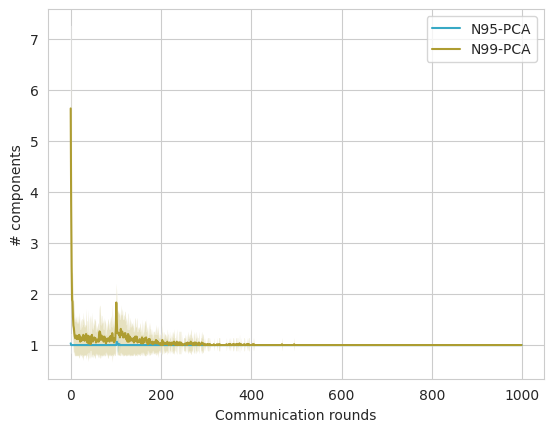

In [24]:
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 5)
epochs = np.arange(len(count_importants))
sns.set_style("whitegrid")
ax.plot(epochs, count_importants, c=clrs[3], label="N95-PCA")
ax.fill_between(epochs, count_importants - count_importants_std, count_importants + count_importants_std, alpha=.3, facecolor=clrs[3])

ax.plot(epochs, count_importants_99, c=clrs[1], label="N99-PCA")
ax.fill_between(epochs, count_importants_99 - count_importants_std_99, count_importants_99 + count_importants_std_99, alpha=.3, facecolor=clrs[1])

# ax.set_ylim([0, 15])
ax.set_ylabel("# components")
ax.set_xlabel("Communication rounds")
ax.legend()

In [26]:
fig.savefig('figures/ml_pca.pdf', bbox_inches='tight')

## Ablation study

### Init B strategies

In [2]:
# project = 'hiue/lowrank-fedrec-2'
# project = 'hiue/lora-fedrec-3'
project = 'hiue/lora-fedrec'
api = wandb.Api()
runs = api.runs(project, {
    "$and": [{
        'config.data.name': 'movielens',
        # 'config.task_name': 'fedtrain',
        'config.model.init._target_': {
            '$in': ['fedlib.lora.models.FedLoraMF']
        },
        # 'tags': {'$elemMatch': {'$eq': 'lora'},},
        'tags': {'$in': ['lora'],},

    }]
})

In [3]:
lora_runs = []
lora_nb_runs = []
lora_ob_runs = []


update_numels = []
all_HR = []
all_NDCG = []
all_loss = []

histories = {}

for run in runs:
    print("Name: {}, Id: {}".format(run.name, run.id))
    if 'lora' in run.name:
        if 'nb' in run.name:
            lora_nb_runs.append(run)
        elif 'ob' in run.name:
            lora_ob_runs.append(run)
        else:
            lora_runs.append(run)
    update_numels.append(run.summary['update_numel'])
    # histories[run.name] = run.history(samples=20)
    histories[run.name] = run.scan_history(keys=['train/loss', 'test/HR', 'test/NDCG', 'epoch'])
    # all_HR.append(run.history()['HR'].max())
    # all_NDCG.append(run.history()['NDCG'].max())
    # all_loss.append(run.history()['train_loss'].min())

Name: fedmf64_lora32ob-60-2-40, Id: lbpt1vt2
Name: fedmf64_lora8ob-60-2-39, Id: 050qdmts
Name: fedmf64_lora2ob-60-2-38, Id: 59z7sy8l
Name: fedmf64_lora16_nb-60-2-37, Id: 2ndvqu1f
Name: fedmf64_lora32_nb-60-2-36, Id: 2ifrr94m
Name: fedmf64_lora8_nb-60-2-35, Id: up68kpmf
Name: fedmf64_lora4_nb-60-2-34, Id: 2nf6gtm1
Name: fedmf64_lora2_nb-60-2-33, Id: 2y1hve6g
Name: fedmf64_lora16_freezeB-60-2-32, Id: 2p2213dr
Name: fedmf64_lora8_freezeB-60-2-20, Id: 6vrftske
Name: fedmf64_lora32_freezeB-60-2-17, Id: 9tjsf2bd
Name: fedmf64_lora4_freezeB-60-2-13, Id: t30yevf7
Name: fedmf64_lora2_freezeB-60-2-12, Id: 7umzn7g0


In [4]:
def scatter_plot(ax, runs, metric, label=None, marker='o', linestyle='dashed', color=None, rescale_x=None, min_value=False, text_offset=0.02):
    x = []
    y = []
    for run in runs:
        # x_val = run.summary['update_numel']
        # if rescale_x is not None:
        #     x_val = x_val / rescale_x
        x_val = run.config['model']['init']['lora_rank']
        x.append(x_val)

        y_val = run.summary[metric]
        # y_val = cached_hist[run.name][metric][np.argmin(cached_hist[run.name]['train/loss'])]
        # metric = metric.split('/')[-1]
        # print(metric)
        # y_val = min(cached_hist[run.name][metric]) if min_value else max(cached_hist[run.name][metric])
        y.append(y_val)
        # if 'lora' in run.name:
        #     lora_rank = run.config['model']['init']['lora_rank']
        #     # ax.text(x_val, y_val+text_offset, f"r={lora_rank}", fontsize=8)
        #     ax.annotate(f"r={lora_rank}", (x_val, y_val), xytext=(x_val, y_val+text_offset), fontsize=8)
        # else:
        #     emb_size = run.config['model']['init']['gmf_emb_size']
        #     ax.text(x_val, y_val-text_offset, f"d={emb_size}", fontsize=8)

    ids = np.argsort(x)
    x = np.array(x)[ids]
    y = np.array(y)[ids]
    ax.plot(x, y, label=label, marker=marker, linestyle=linestyle, color=color)

Text(0, 0.5, 'Train loss')

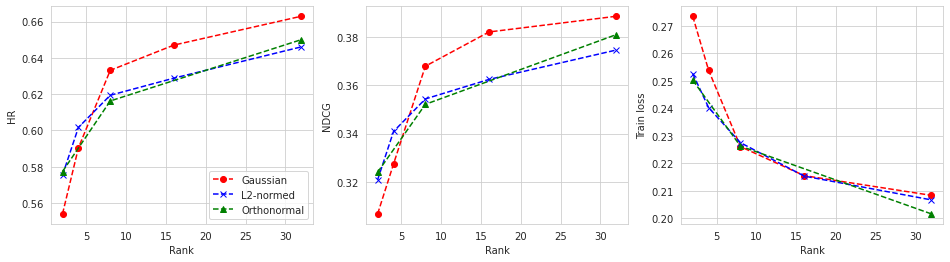

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
with sns.axes_style("whitegrid"):
    scatter_plot(axes[0], lora_runs, 'test/HR', label='Gaussian', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels), text_offset=0.02)
    scatter_plot(axes[0], lora_nb_runs, 'test/HR', label='L2-normed', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels), text_offset=0.02)
    scatter_plot(axes[0], lora_ob_runs, 'test/HR', label='Orthonormal', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels), text_offset=0.02)
    axes[0].set_xlabel('Rank')
    axes[0].set_ylabel('HR')
    axes[0].legend()
    # axes[0].set_ylim([0.1, 0.5])
    # axes[0].axhline(y=max(all_HR), color='black', linestyle='-.')

    scatter_plot(axes[1], lora_runs, 'test/NDCG', label='Gaussian', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels), text_offset=0.01)
    scatter_plot(axes[1], lora_nb_runs, 'test/NDCG', label='L2-normed', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels), text_offset=0.01)
    scatter_plot(axes[1], lora_ob_runs, 'test/NDCG', label='Orthonormal', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels), text_offset=0.01)
    axes[1].set_xlabel('Rank')
    axes[1].set_ylabel('NDCG')
# axes[1].set_ylim([0.15, 0.3])
# axes[1].axhline(y=max(all_NDCG), color='black', linestyle='-.')


scatter_plot(axes[2], lora_runs, 'train/loss', label='LoRA', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels), min_value=True, text_offset=0.01)
scatter_plot(axes[2], lora_nb_runs, 'train/loss', label='SVD', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels), min_value=True, text_offset=0.01)
scatter_plot(axes[2], lora_ob_runs, 'train/loss', label='Orthonormal', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels), min_value=True, text_offset=0.01)
axes[2].set_xlabel('Rank')
axes[2].set_ylabel('Train loss')
# axes[2].set_ylim([0.4, 0.6])

In [7]:
fig.savefig('figures/ml-compare-init-strategies.pdf', bbox_inches='tight')